# 🔍 Complete Filtering & Pair Extraction Notebook
This notebook combines the steps for multi-language filtering and subsequent pair extraction.

## 🌍 Section 1: Filtering All Languages (`filtrado_2_extra_all_languages.ipynb`)

In [1]:
%pip install fuzzywuzzy

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importing necessary libraries
import pandas as pd
from fuzzywuzzy import fuzz

c:\Users\Eneas\anaconda3\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# FILE PATHS

In [3]:
# Define paths to the CSV files
csv_paths = {
    "EN_ES": '../original_data_tzos/EN_ES.csv',
    "ES_EN": '../original_data_tzos/ES_EN.csv',
    "EN_BA": '../original_data_tzos/EN_BA.csv',
    "BA_EN": '../original_data_tzos/BA_EN.csv',
    "ES_BA": '../original_data_tzos/ES_BA.csv',
    "BA_ES": '../original_data_tzos/BA_ES.csv'
}

# Load the CSV files into DataFrames
# Each file is read with tab-separated values and assigned standardized column names
dataframes = {}
for key, path in csv_paths.items():
    # Read the CSV file and assign column names based on the language pair
    if key in ["EN_ES"]:
        columns = ['english', 'spanish', 'context']
    elif key in ["ES_EN"]:
        columns = ['spanish', 'english', 'context']
    elif key in ["EN_BA"]:
        columns = ['english', 'basque', 'context']
    elif key in ["BA_EN"]:
        columns = ['basque', 'english', 'context']
    elif key in ["ES_BA"]:
        columns = ['spanish', 'basque', 'context']
    elif key in ["BA_ES"]:
        columns = ['basque', 'spanish', 'context']
    else:
        raise ValueError(f"Unexpected key: {key}")

    # Load the DataFrame and store it in the dictionary
    dataframes[key] = pd.read_csv(path, sep='\t', names=columns)

# Assign the loaded DataFrames to variables for easier access
df_en_es = dataframes["EN_ES"]
df_es_en = dataframes["ES_EN"]
df_en_ba = dataframes["EN_BA"]
df_ba_en = dataframes["BA_EN"]
df_es_ba = dataframes["ES_BA"]
df_ba_es = dataframes["BA_ES"]

# EN-ES

## Most polysemous term

In [4]:
# Group by the English term and count unique Spanish translations
unique_translations_count = df_en_es.groupby('english')['spanish'].nunique()

# Sort in descending order to find the terms with the most polysemy
sorted_polysemy_en_es = unique_translations_count.sort_values(ascending=False)

# Display the top 10 most polysemous terms and their unique translations
print("Top 10 most polysemous terms in EN-ES:")
print(sorted_polysemy_en_es.head(10))

# Display all terms sorted by polysemy
print("\nAll terms sorted by polysemy in EN-ES:")
print(sorted_polysemy_en_es)

Top 10 most polysemous terms in EN-ES:
english
buffer          7
range           6
lattice         6
momentum        6
steady state    6
waste           5
phase shift     5
stress          5
charge          5
link            5
Name: spanish, dtype: int64

All terms sorted by polysemy in EN-ES:
english
buffer                           7
range                            6
lattice                          6
momentum                         6
steady state                     6
                                ..
generating line                  2
geographic information system    2
glucose                          2
gram                             2
working capital                  2
Name: spanish, Length: 721, dtype: int64


## External Polysemy

In [5]:
# Function to group similar translations based on a similarity threshold
def group_similar_translations(translations, threshold=98):
    """
    Groups similar translations based on a similarity threshold.

    Args:
        translations (list): List of translations to be grouped.
        threshold (int): Similarity threshold (default is 98).

    Returns:
        list: List of unique translations after grouping similar ones.
    """
    unique_translations = []
    for translation in translations:
        translation = translation.strip()  # Remove extra spaces before comparison
        if not any(fuzz.ratio(translation, unique.strip()) > threshold for unique in unique_translations):
            unique_translations.append(translation)
    return unique_translations

# Function to filter terms by context and identify polysemous terms
def filter_by_context(dataframe, source_lang, target_lang):
    """
    Filters terms by context and identifies polysemous terms with more than one unique translation.

    Args:
        dataframe (pd.DataFrame): DataFrame containing terms, translations, and contexts.
        source_lang (str): Column name for the source language.
        target_lang (str): Column name for the target language.

    Returns:
        dict: Dictionary of terms with their valid contexts and translations.
    """
    grouped_terms = dataframe.groupby(source_lang)
    filtered_results = {}

    for term, group in grouped_terms:
        # Get unique combinations of translations and contexts
        unique_combinations = group[[target_lang, 'context']].drop_duplicates()
        unique_contexts = unique_combinations.groupby('context')[target_lang].apply(
            lambda x: group_similar_translations(x.unique(), threshold=90)
        )

        # Filter terms with more than one unique translation across all contexts
        total_translations = group_similar_translations(group[target_lang].unique(), threshold=90)

        if len(total_translations) > 1:  # Only consider terms with more than one translation
            valid_contexts = unique_contexts[unique_contexts.apply(len) > 0]
            if len(valid_contexts) > 1:  # Ensure translations exist in more than one context
                filtered_results[term] = valid_contexts

    return filtered_results

# Apply the filtering function to the DataFrame
filtered_polysemous_terms = filter_by_context(df_en_es, 'english', 'spanish')

# Sort the filtered terms by the number of different contexts with translations
sorted_filtered_terms = sorted(filtered_polysemous_terms.items(), key=lambda x: len(x[1]), reverse=True)

# Display results
total_filtered_terms = len(sorted_filtered_terms)
print(f"\nTotal number of polysemous terms after filtering by contexts: {total_filtered_terms}")



Total number of polysemous terms after filtering by contexts: 636


## Internal Polysemy

In [6]:
# Additional filter: Remove duplicate translations within the same context
def remove_internal_polysemy(term_contexts):
    """
    Removes internal polysemy by keeping only one unique translation per context.

    Args:
        term_contexts (dict): Dictionary where keys are terms and values are dictionaries 
                              of contexts and their associated translations.

    Returns:
        dict: Dictionary with terms and filtered contexts containing only one translation each.
    """
    filtered_terms = {}
    for term, contexts in term_contexts.items():
        filtered_contexts = {}
        for context, translations in contexts.items():
            # Group similar translations and keep only the first unique translation
            unique_translations = group_similar_translations(translations)
            filtered_contexts[context] = unique_translations[:1]  # Keep only one translation per context
        filtered_terms[term] = filtered_contexts
    return filtered_terms

# Apply the context-based filtering function to the DataFrame
filtered_terms_by_context = filter_by_context(df_en_es, 'english', 'spanish')

# Apply the internal polysemy removal filter
filtered_terms_no_internal_polysemy = remove_internal_polysemy(filtered_terms_by_context)

# Sort the filtered terms by the number of different contexts with translations
sorted_filtered_terms = sorted(filtered_terms_no_internal_polysemy.items(), key=lambda x: len(x[1]), reverse=True)

# Display results
total_filtered_terms = len(sorted_filtered_terms)
print(f"\nTotal number of polysemous terms after filtering by contexts and removing internal polysemy: {total_filtered_terms}")


Total number of polysemous terms after filtering by contexts and removing internal polysemy: 636


## Saved as filtered CSV extra

In [7]:
# Filter the original DataFrame using polysemous terms after considering different contexts
polysemous_terms = list(filtered_terms_by_context.keys())  # Terms in English with more than one valid context
filtered_df_en_es = df_en_es[df_en_es['english'].isin(polysemous_terms)]

# Save the filtered DataFrame to the specified path
output_path = 'generated_files/EN_ES_filtered_extra.csv'
filtered_df_en_es.to_csv(output_path, index=False)

print(f"The filtered DataFrame has been saved as 'EN_ES_filtered_extra.csv' at the specified path.")

The filtered DataFrame has been saved as 'EN_ES_filtered_extra.csv' at the specified path.


# ES-EN

## Most Polysemous Term

In [8]:
# Group by the Spanish term and count unique English translations
unique_english_translations = df_es_en.groupby('spanish')['english'].nunique()

# Sort in descending order to find the terms with the most polysemy
sorted_polysemy_es_en = unique_english_translations.sort_values(ascending=False)

# Display the top 10 most polysemous terms and their unique translations
print("Top 10 most polysemous terms in ES-EN:")
print(sorted_polysemy_es_en.head(10))

# Display all terms sorted by polysemy
print("\nAll terms sorted by polysemy in ES-EN:")
print(sorted_polysemy_es_en)

Top 10 most polysemous terms in ES-EN:
spanish
corte                      7
rendimiento                7
velocidad                  7
diferencia de potencial    7
residuo                    6
alimentación               6
momento                    6
recubrimiento              6
carga                      5
capacidad                  5
Name: english, dtype: int64

All terms sorted by polysemy in ES-EN:
spanish
corte                      7
rendimiento                7
velocidad                  7
diferencia de potencial    7
residuo                    6
                          ..
macrófago                  1
líquido                    1
lote                       1
lisina                     1
órgano                     1
Name: english, Length: 1446, dtype: int64


## External Polysemy

In [9]:
# Apply the filtering function to the DataFrame
filtered_results_es_en = filter_by_context(df_es_en, 'spanish', 'english')

# Sort the filtered terms by the number of different contexts with translations
sorted_filtered_results = sorted(filtered_results_es_en.items(), key=lambda x: len(x[1]), reverse=True)

# Display results
total_filtered_terms = len(sorted_filtered_results)
print(f"\nTotal number of polysemous terms in ES-EN after filtering by contexts: {total_filtered_terms}")



Total number of polysemous terms in ES-EN after filtering by contexts: 1000


## Internal Polysemy

In [10]:
# Apply the filtering function to the DataFrame
filtered_terms_by_context = filter_by_context(df_es_en, 'spanish', 'english')

# Apply the internal polysemy removal filter
filtered_terms_no_internal_polysemy = remove_internal_polysemy(filtered_terms_by_context)

# Sort the filtered terms by the number of different contexts with translations
sorted_filtered_terms = sorted(filtered_terms_no_internal_polysemy.items(), key=lambda x: len(x[1]), reverse=True)

# Display results
total_filtered_terms = len(sorted_filtered_terms)
print(f"\nTotal number of polysemous terms in ES-EN after filtering by contexts and removing internal polysemy: {total_filtered_terms}")


Total number of polysemous terms in ES-EN after filtering by contexts and removing internal polysemy: 1000


## Saved as filtered CSV extra

In [11]:
# Filter the original DataFrame using polysemous terms after considering different contexts
polysemous_terms = list(filtered_results_es_en.keys())  # Spanish terms with more than one valid context
filtered_df_es_en = df_es_en[df_es_en['spanish'].isin(polysemous_terms)]

# Save the filtered DataFrame to the specified path
output_file_path = 'generated_files/ES_EN_filtered_extra.csv'
filtered_df_es_en.to_csv(output_file_path, index=False)

print(f"The filtered DataFrame has been saved as 'ES_EN_filtered_extra.csv' at the specified path.")

The filtered DataFrame has been saved as 'ES_EN_filtered_extra.csv' at the specified path.


# EN-BA

## Most Polysemous Term

In [12]:
# Group by the English term and count unique Basque translations
unique_basque_translations = df_en_ba.groupby('english')['basque'].nunique()

# Sort in descending order to find the terms with the highest polysemy
sorted_polysemy_en_ba = unique_basque_translations.sort_values(ascending=False)

# Display the top 10 most polysemous terms and their unique translations
print("Top 10 most polysemous terms in EN-BA:")
print(sorted_polysemy_en_ba.head(10))

# Display all terms sorted by polysemy
print("\nAll terms sorted by polysemy in EN-BA:")
print(sorted_polysemy_en_ba)

Top 10 most polysemous terms in EN-BA:
english
range                 8
charge                7
generator             7
standard deviation    7
steady state          7
joint                 6
momentum              6
test                  6
frame                 6
conductivity          6
Name: basque, dtype: int64

All terms sorted by polysemy in EN-BA:
english
range                        8
charge                       7
generator                    7
standard deviation           7
steady state                 7
                            ..
law of decreasing returns    2
layer                        2
leaching                     2
lead                         2
zigzag line                  2
Name: basque, Length: 1068, dtype: int64


## External Polysemy

In [13]:
# Apply the filtering function to the DataFrame
filtered_results_en_ba = filter_by_context(df_en_ba, 'english', 'basque')

# Sort the filtered terms by the number of different contexts with translations
sorted_filtered_results = sorted(filtered_results_en_ba.items(), key=lambda x: len(x[1]), reverse=True)

# Display results
total_filtered_terms = len(sorted_filtered_results)
print(f"\nTotal number of polysemous terms in EN-BA after filtering by contexts: {total_filtered_terms}")


Total number of polysemous terms in EN-BA after filtering by contexts: 985


## Internal Polysemy

In [14]:
# Apply the filtering function to the DataFrame
filtered_terms_by_context = filter_by_context(df_en_ba, 'english', 'basque')

# Apply the internal polysemy removal filter
filtered_terms_no_internal_polysemy = remove_internal_polysemy(filtered_terms_by_context)

# Sort the filtered terms by the number of different contexts with translations
sorted_filtered_terms = sorted(filtered_terms_no_internal_polysemy.items(), key=lambda x: len(x[1]), reverse=True)

# Display results
total_filtered_terms = len(sorted_filtered_terms)
print(f"\nTotal number of polysemous terms in EN-BA after filtering by contexts and removing internal polysemy: {total_filtered_terms}")


Total number of polysemous terms in EN-BA after filtering by contexts and removing internal polysemy: 985


## Saved as filtered CSV extra

In [15]:
# Filter the original DataFrame using polysemous terms after considering different contexts
# Extract the list of polysemous terms from the filtered results
polysemous_terms = list(filtered_results_en_ba.keys())

# Filter the DataFrame to include only rows where the English term is in the list of polysemous terms
filtered_df_en_ba = df_en_ba[df_en_ba['english'].isin(polysemous_terms)]

# Define the output file path for the filtered DataFrame
output_file_path = 'generated_files/EN_BA_filtered_extra.csv'

# Save the filtered DataFrame to the specified path
filtered_df_en_ba.to_csv(output_file_path, index=False)

# Print confirmation message
print(f"The filtered DataFrame has been saved as '{output_file_path}' at the specified path.")

The filtered DataFrame has been saved as 'generated_files/EN_BA_filtered_extra.csv' at the specified path.


# BA-EN

## Most Polysemous Term

In [16]:
# Group by the Basque term and count unique English translations
unique_english_translations = df_ba_en.groupby('basque')['english'].nunique()

# Sort in descending order to find the terms with the highest polysemy
sorted_polysemy_ba_en = unique_english_translations.sort_values(ascending=False)

# Display the top 10 most polysemous terms and their unique translations
print("Top 10 most polysemous terms in Basque to English:")
print(sorted_polysemy_ba_en.head(10))

# Display all terms sorted by polysemy
print("\nAll terms sorted by polysemy in Basque to English:")
print(sorted_polysemy_ba_en)

Top 10 most polysemous terms in Basque to English:
basque
abiadura                  9
maila                     8
momentu                   7
ingurune                  7
potentzial-diferentzia    7
hondar                    7
elikadura                 6
zunda                     6
haustura                  6
hartzaile                 6
Name: english, dtype: int64

All terms sorted by polysemy in Basque to English:
basque
abiadura                  9
maila                     8
momentu                   7
ingurune                  7
potentzial-diferentzia    7
                         ..
mintz                     1
minbizi-zelula            1
domeinu                   1
metodologia               1
zuzentarau                1
Name: english, Length: 1502, dtype: int64


## External Polysemy

In [17]:
# Apply the filtering function to the DataFrame
filtered_results_ba_en = filter_by_context(df_ba_en, 'basque', 'english')

# Sort the filtered terms by the number of different contexts with translations
sorted_filtered_results = sorted(filtered_results_ba_en.items(), key=lambda x: len(x[1]), reverse=True)

# Display results
total_filtered_terms = len(sorted_filtered_results)
print(f"\nTotal number of polysemous terms in BA-EN after filtering by contexts: {total_filtered_terms}")


Total number of polysemous terms in BA-EN after filtering by contexts: 1083


## Internal Polysemy

In [18]:
# Apply the filtering function to the DataFrame
filtered_terms_by_context = filter_by_context(df_ba_en, 'basque', 'english')

# Apply the internal polysemy removal filter
filtered_terms_no_internal_polysemy = remove_internal_polysemy(filtered_terms_by_context)

# Sort the filtered terms by the number of different contexts with translations
sorted_filtered_terms = sorted(filtered_terms_no_internal_polysemy.items(), key=lambda x: len(x[1]), reverse=True)

# Display results
total_filtered_terms = len(sorted_filtered_terms)
print(f"\nTotal number of polysemous terms in BA-EN after filtering by contexts and removing internal polysemy: {total_filtered_terms}")


Total number of polysemous terms in BA-EN after filtering by contexts and removing internal polysemy: 1083


## Saved as filtered extra CSV

In [19]:
# Filter the original DataFrame using polysemous terms after considering different contexts
# Extract the list of polysemous terms from the filtered results
polysemous_terms = list(filtered_results_ba_en.keys())  # Basque terms with more than one valid context

# Filter the DataFrame to include only rows where the Basque term is in the list of polysemous terms
filtered_df_ba_en = df_ba_en[df_ba_en['basque'].isin(polysemous_terms)]

# Define the output file path for the filtered DataFrame
output_file_path = 'generated_files/BA_EN_filtered_extra.csv'

# Save the filtered DataFrame to the specified path
filtered_df_ba_en.to_csv(output_file_path, index=False)

# Print confirmation message
print(f"The filtered DataFrame has been saved as '{output_file_path}' at the specified path.")

The filtered DataFrame has been saved as 'generated_files/BA_EN_filtered_extra.csv' at the specified path.


# ES-BA

## Most Polysemous Term

In [20]:
# Group by the Spanish term and count unique Basque translations
unique_basque_translations_count = df_es_ba.groupby('spanish')['basque'].nunique()

# Sort in descending order to find the terms with the highest polysemy
sorted_polysemy_es_ba = unique_basque_translations_count.sort_values(ascending=False)

# Display the top 10 most polysemous terms and their unique translations
print("Top 10 most polysemous terms in ES-EU:")
print(sorted_polysemy_es_ba.head(10))

# Display all terms sorted by polysemy
print("\nAll terms sorted by polysemy in ES-EU:")
print(sorted_polysemy_es_ba)

Top 10 most polysemous terms in ES-EU:
spanish
competencia    10
suspensión      7
obligación      7
capacidad       7
valoración      7
sociedad        7
error           7
prueba          7
conducción      7
reducción       7
Name: basque, dtype: int64

All terms sorted by polysemy in ES-EU:
spanish
competencia              10
suspensión                7
obligación                7
capacidad                 7
valoración                7
                         ..
estratificación           2
estructura cristalina     2
estructura molecular      2
estéril                   2
impulsar                  2
Name: basque, Length: 1388, dtype: int64


## External Polysemy

In [21]:
# Apply the filtering function to the DataFrame
filtered_results_es_ba = filter_by_context(df_es_ba, 'spanish', 'basque')

# Sort the filtered terms by the number of different contexts with translations
sorted_filtered_results = sorted(filtered_results_es_ba.items(), key=lambda x: len(x[1]), reverse=True)

# Display results
total_filtered_terms = len(sorted_filtered_results)
print(f"\nTotal number of polysemous terms in ES-BA after filtering by contexts: {total_filtered_terms}")


Total number of polysemous terms in ES-BA after filtering by contexts: 1281


## Internal Polysemy

In [22]:
# Apply the filtering function to the DataFrame
filtered_terms_by_context = filter_by_context(df_es_ba, 'spanish', 'basque')

# Apply the internal polysemy removal filter
filtered_terms_no_internal_polysemy = remove_internal_polysemy(filtered_terms_by_context)

# Sort the filtered terms by the number of different contexts with translations
sorted_filtered_terms = sorted(filtered_terms_no_internal_polysemy.items(), key=lambda x: len(x[1]), reverse=True)

# Display results
total_filtered_terms = len(sorted_filtered_terms)
print(f"\nTotal number of polysemous terms in ES-BA after filtering by contexts and removing internal polysemy: {total_filtered_terms}")


Total number of polysemous terms in ES-BA after filtering by contexts and removing internal polysemy: 1281


## Saved as filtered extra CSV

In [23]:
# Filter the original DataFrame using polysemous terms after considering different contexts
# Extract the list of polysemous terms from the filtered results
polysemous_terms = list(filtered_results_es_ba.keys())  # Spanish terms with more than one valid context

# Filter the DataFrame to include only rows where the Spanish term is in the list of polysemous terms
filtered_df_es_ba = df_es_ba[df_es_ba['spanish'].isin(polysemous_terms)]

# Define the output file path for the filtered DataFrame
output_file_path = 'generated_files/ES_BA_filtered_extra.csv'

# Save the filtered DataFrame to the specified path
filtered_df_es_ba.to_csv(output_file_path, index=False)

# Print confirmation message
print(f"The filtered DataFrame has been saved as '{output_file_path}' at the specified path.")

The filtered DataFrame has been saved as 'generated_files/ES_BA_filtered_extra.csv' at the specified path.


# BA-ES

## Most Polysemous Term

In [24]:
# Group by the Basque term and count unique Spanish translations
unique_spanish_translations = df_ba_es.groupby('basque')['spanish'].nunique() # Sort in descending order to find the terms with the highest polysemy
sorted_polysemy_ba_es = unique_spanish_translations.sort_values(ascending=False)

# Display the top 10 most polysemous terms and their unique translations
print("Top 10 most polysemous terms in Basque to Spanish:")
print(sorted_polysemy_ba_es.head(10))
# Display all terms sorted by polysemy
print("\nAll terms sorted by polysemy in Basque to Spanish:")
print(sorted_polysemy_ba_es)

Top 10 most polysemous terms in Basque to Spanish:
basque
hartzaile    8
maila        7
adostasun    7
jabe         6
betebehar    6
auzi         6
hedapen      6
haustura     6
tentsio      6
ebakidura    6
Name: spanish, dtype: int64

All terms sorted by polysemy in Basque to Spanish:
basque
hartzaile                   8
maila                       7
adostasun                   7
jabe                        6
betebehar                   6
                           ..
errege-dekretu              2
erregelamendu betearazle    2
errekonbentzio-demanda      2
zuzkidura                   2
difusio                     1
Name: spanish, Length: 1034, dtype: int64


## External Polysemy

In [25]:
# Apply the filtering function to the DataFrame
filtered_results_ba_es = filter_by_context(df_ba_es, 'basque', 'spanish')

# Sort the filtered terms by the number of different contexts with translations
sorted_filtered_results = sorted(filtered_results_ba_es.items(), key=lambda x: len(x[1]), reverse=True)

# Display results
total_filtered_terms = len(sorted_filtered_results)
print(f"\nTotal number of polysemous terms in BA-ES after filtering by contexts: {total_filtered_terms}")


Total number of polysemous terms in BA-ES after filtering by contexts: 913


## Internal Polysemy

In [26]:
# Apply the filtering function to the DataFrame
filtered_terms_by_context = filter_by_context(df_ba_es, 'basque', 'spanish')

# Apply the internal polysemy removal filter
filtered_terms_no_internal_polysemy = remove_internal_polysemy(filtered_terms_by_context)

# Sort the filtered terms by the number of different contexts with translations
sorted_filtered_terms = sorted(filtered_terms_no_internal_polysemy.items(), key=lambda x: len(x[1]), reverse=True)

# Display results
total_filtered_terms = len(sorted_filtered_terms)
print(f"\nTotal number of polysemous terms in BA-ES after filtering by contexts and removing internal polysemy: {total_filtered_terms}")


Total number of polysemous terms in BA-ES after filtering by contexts and removing internal polysemy: 913


## Saved as filtered extra CSV

In [27]:
# Filter the original DataFrame using polysemous terms after considering different contexts
# Extract the list of polysemous terms from the filtered results
polysemous_terms = list(filtered_results_ba_es.keys())  # Basque terms with more than one valid context

# Filter the DataFrame to include only rows where the Basque term is in the list of polysemous terms
filtered_df_ba_es = df_ba_es[df_ba_es['basque'].isin(polysemous_terms)]

# Define the output file path for the filtered DataFrame
output_file_path = 'generated_files/BA_ES_filtered_extra.csv'

# Save the filtered DataFrame to the specified path
filtered_df_ba_es.to_csv(output_file_path, index=False)

# Print confirmation message
print(f"The filtered DataFrame has been saved as '{output_file_path}' at the specified path.")

The filtered DataFrame has been saved as 'generated_files/BA_ES_filtered_extra.csv' at the specified path.


## 📁 Section 2: Pair Extraction (`filtrado_2_obtencion_parejas.ipynb`)

In [28]:
# Importing necessary libraries
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import os

# FILE PATHS

In [29]:
# Paths to the filtered CSV files
filtered_csv_paths = {
    "EN_ES": 'generated_files/EN_ES_filtered_extra.csv',
    "ES_EN": 'generated_files/ES_EN_filtered_extra.csv',
    "EN_BA": 'generated_files/EN_BA_filtered_extra.csv',
    "BA_EN": 'generated_files/BA_EN_filtered_extra.csv',
    "ES_BA": 'generated_files/ES_BA_filtered_extra.csv',
    "BA_ES": 'generated_files/BA_ES_filtered_extra.csv'
}

# Load the filtered CSV files into DataFrames
# Ensure that the column names are consistent across all DataFrames
dataframes = {}
for key, path in filtered_csv_paths.items():
    df = pd.read_csv(path)
    df.columns = ['term', 'translation', 'context']  # Standardize column names
    dataframes[key] = df

# Example: Accessing the DataFrame for EN-ES
df_en_es = dataframes["EN_ES"]
df_es_en = dataframes["ES_EN"]
df_en_ba = dataframes["EN_BA"]
df_ba_en = dataframes["BA_EN"]
df_es_ba = dataframes["ES_BA"]
df_ba_es = dataframes["BA_ES"]

# EXTRACT MOST FREQUENT PAIRS

In [30]:
# List of DataFrames and their corresponding names
dataframes_with_names = [
    (df_en_es, "EN-ES"),
    (df_es_en, "ES-EN"),
    (df_en_ba, "EN-BA"),
    (df_ba_en, "BA-EN"),
    (df_es_ba, "ES-BA"),
    (df_ba_es, "BA-ES")
]

# Process each DataFrame individually
for dataframe, language_pair in dataframes_with_names:
    # Dictionary to store terms and their unique contexts
    term_context_mapping = {}

    # Populate the dictionary with terms and their unique contexts
    for _, row in dataframe.iterrows():
        term = row['term']
        context = row['context']
        translation = row['translation']

        if term not in term_context_mapping:
            term_context_mapping[term] = {}
        if context not in term_context_mapping[term]:
            term_context_mapping[term][context] = set()

        term_context_mapping[term][context].add(translation)

    # Counter to track pairs of contexts with different translations
    context_pair_counter = Counter()

    for term, contexts in term_context_mapping.items():
        context_list = list(contexts.keys())
        for i in range(len(context_list)):
            for j in range(i + 1, len(context_list)):
                context1, context2 = context_list[i], context_list[j]
                translations1 = contexts[context1]
                translations2 = contexts[context2]

                # Count only if the translations are different
                if translations1 != translations2:
                    context_pair = tuple(sorted([context1, context2]))
                    context_pair_counter[context_pair] += 1

    # Retrieve the 10 most frequent context pairs for this DataFrame
    top_10_context_pairs = context_pair_counter.most_common(10)

    # Display the results
    print(f"\nThe 10 most frequent context pairs in {language_pair} are:")
    for context_pair, count in top_10_context_pairs:
        print(f"Context Pair: {context_pair}, Occurrences: {count}")


The 10 most frequent context pairs in EN-ES are:
Context Pair: ('Medical Sciences > Pharmaceutical Technology', 'Technological Sciences > Environmental technology and engineering'), Occurrences: 39
Context Pair: ('Physics > Electro-magnetism', 'Technological Sciences > Electrical technology and engineering'), Occurrences: 37
Context Pair: ('Technological Sciences > Electrical technology and engineering', 'Technological Sciences > Environmental technology and engineering'), Occurrences: 30
Context Pair: ('Technological Sciences > Environmental technology and engineering', 'Technological Sciences > Projects'), Occurrences: 27
Context Pair: ('Physics > Electro-magnetism', 'Technological Sciences > Environmental technology and engineering'), Occurrences: 27
Context Pair: ('Chemistry > Analytical chemistry', 'Technological Sciences > Environmental technology and engineering'), Occurrences: 26
Context Pair: ('Technological Sciences > Electrical technology and engineering', 'Technological Sc

# CREATE GRAPH

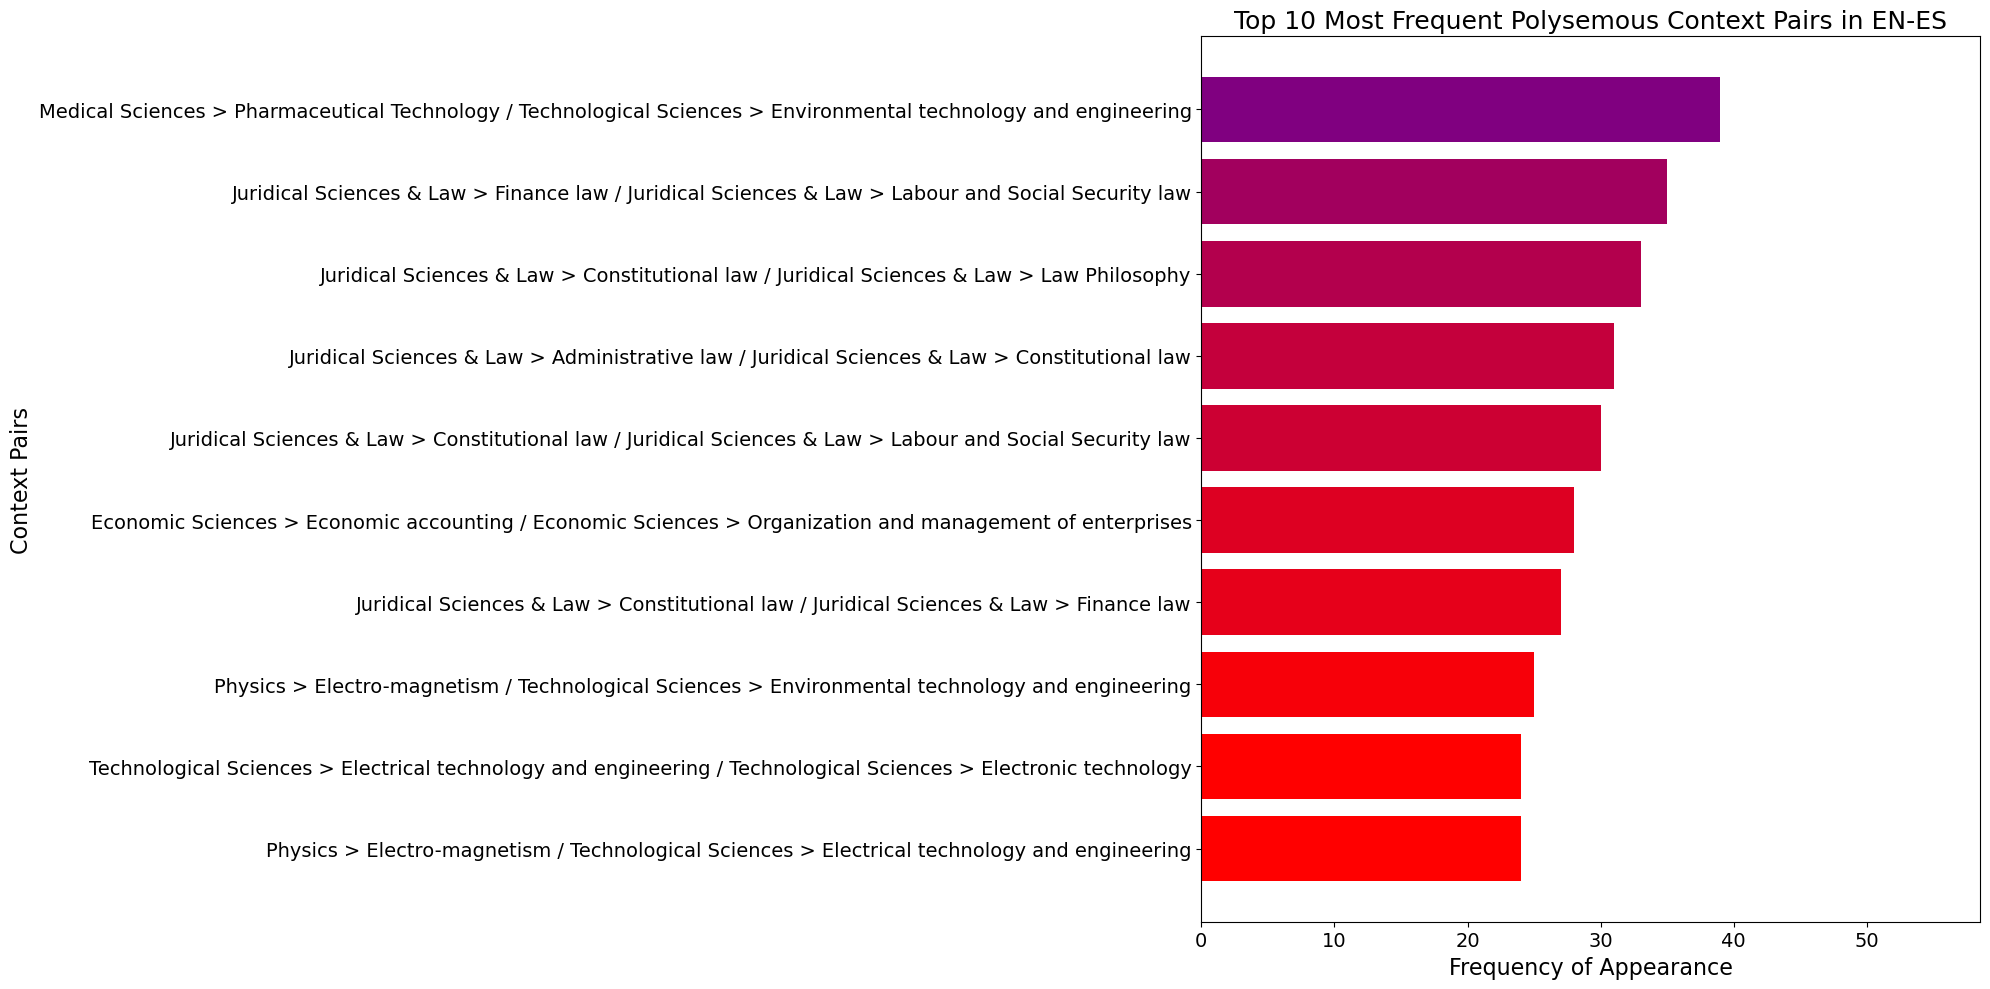

In [31]:
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import matplotlib.pyplot as plt

# Extract pairs and their counts, sorted by frequency in descending order
pairs, counts = zip(*sorted(top_10_context_pairs, key=lambda x: x[1], reverse=True))
pair_labels = [f"{p[0]} / {p[1]}" for p in pairs]

# Create a gradient color map (e.g., from red to purple)
color_map = LinearSegmentedColormap.from_list("gradient_colormap", ["red", "purple"])

# Normalize frequency values for the gradient
color_normalizer = plt.Normalize(min(counts), max(counts))
bar_colors = color_map(color_normalizer(counts))  # Generate gradient colors for each bar

# Create a horizontal bar chart with gradient colors
plt.figure(figsize=(20, 10))  # Wider figure for better visualization
bars = plt.barh(pair_labels, counts, color=bar_colors)

# Adjust the x-axis limit to extend bars and add margin
plt.xlim(0, max(counts) * 1.5)  # Increase the maximum range by 50%

# Add labels and title
plt.xlabel('Frequency of Appearance', fontsize=16)
plt.ylabel('Context Pairs', fontsize=16)
plt.title('Top 10 Most Frequent Polysemous Context Pairs in EN-ES', fontsize=18)
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)  # Increase font size for y-axis labels
plt.tight_layout()  # Adjust layout to prevent overlap

# Display the plot
plt.show()


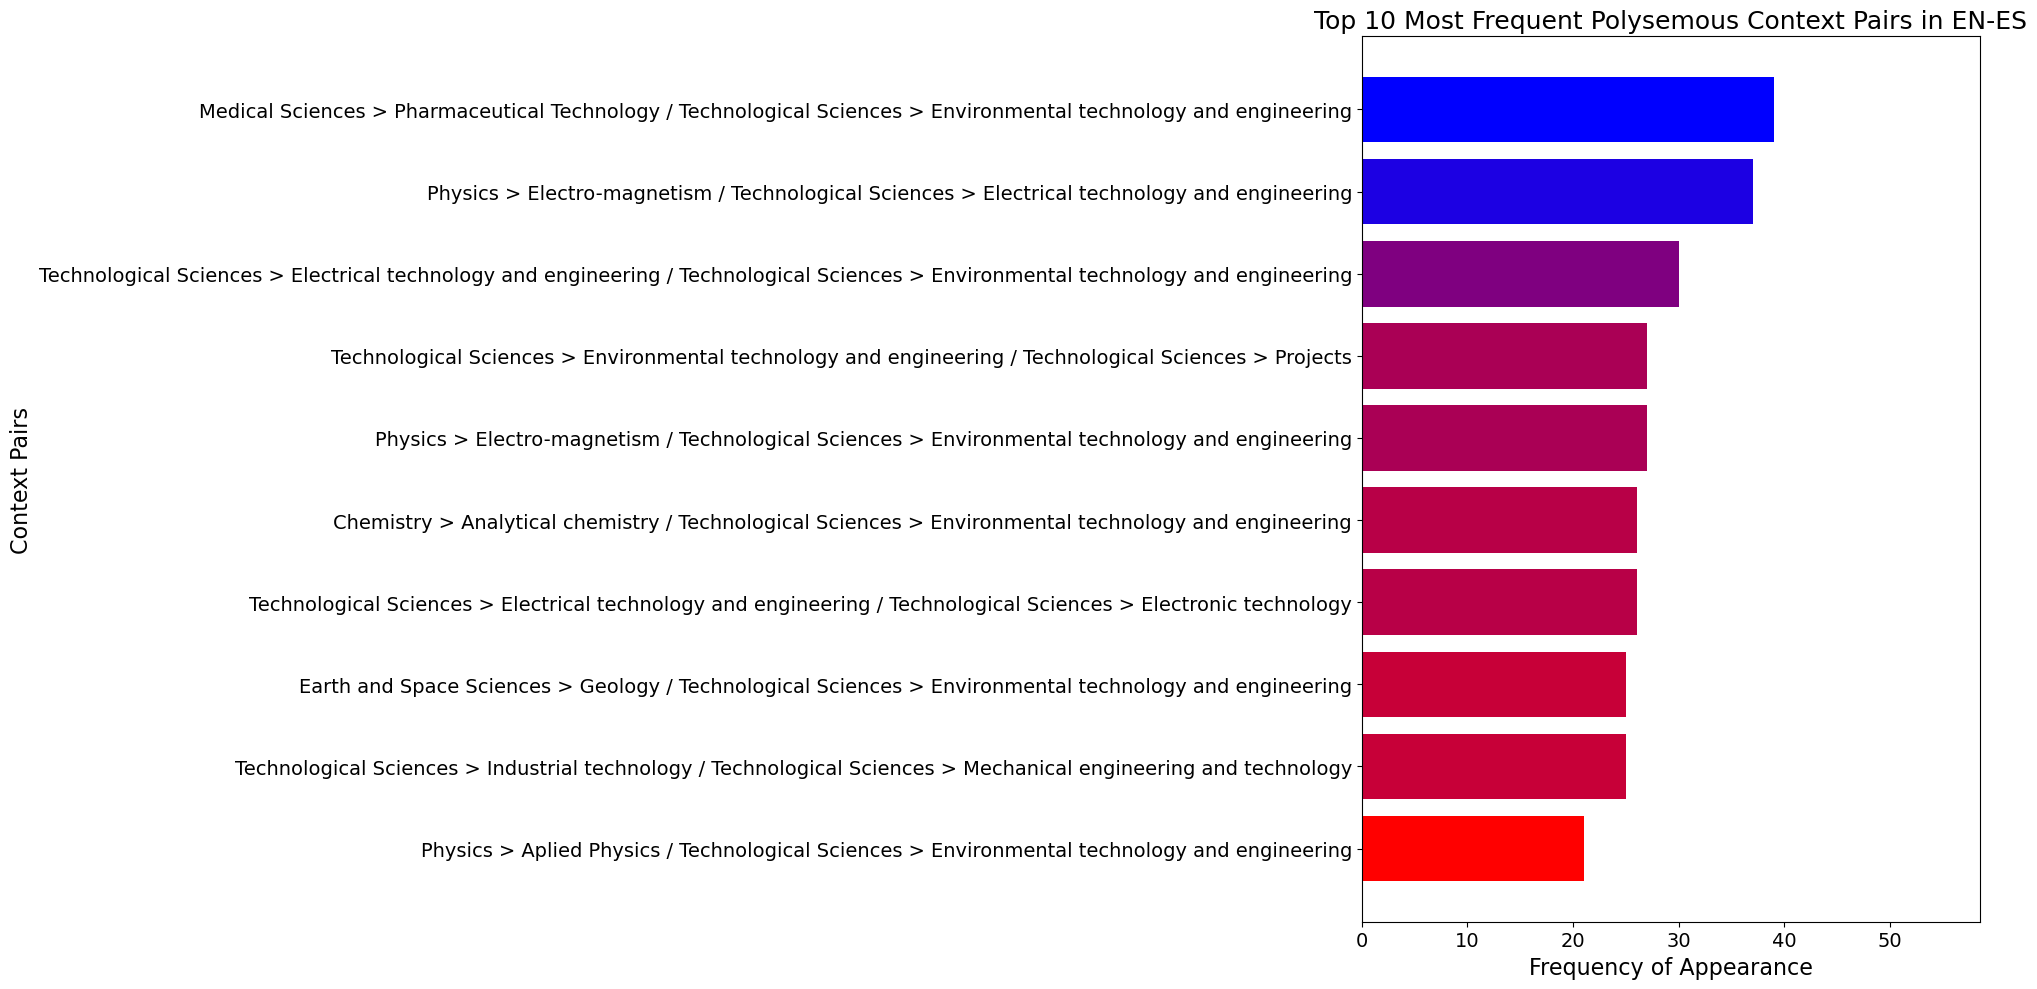

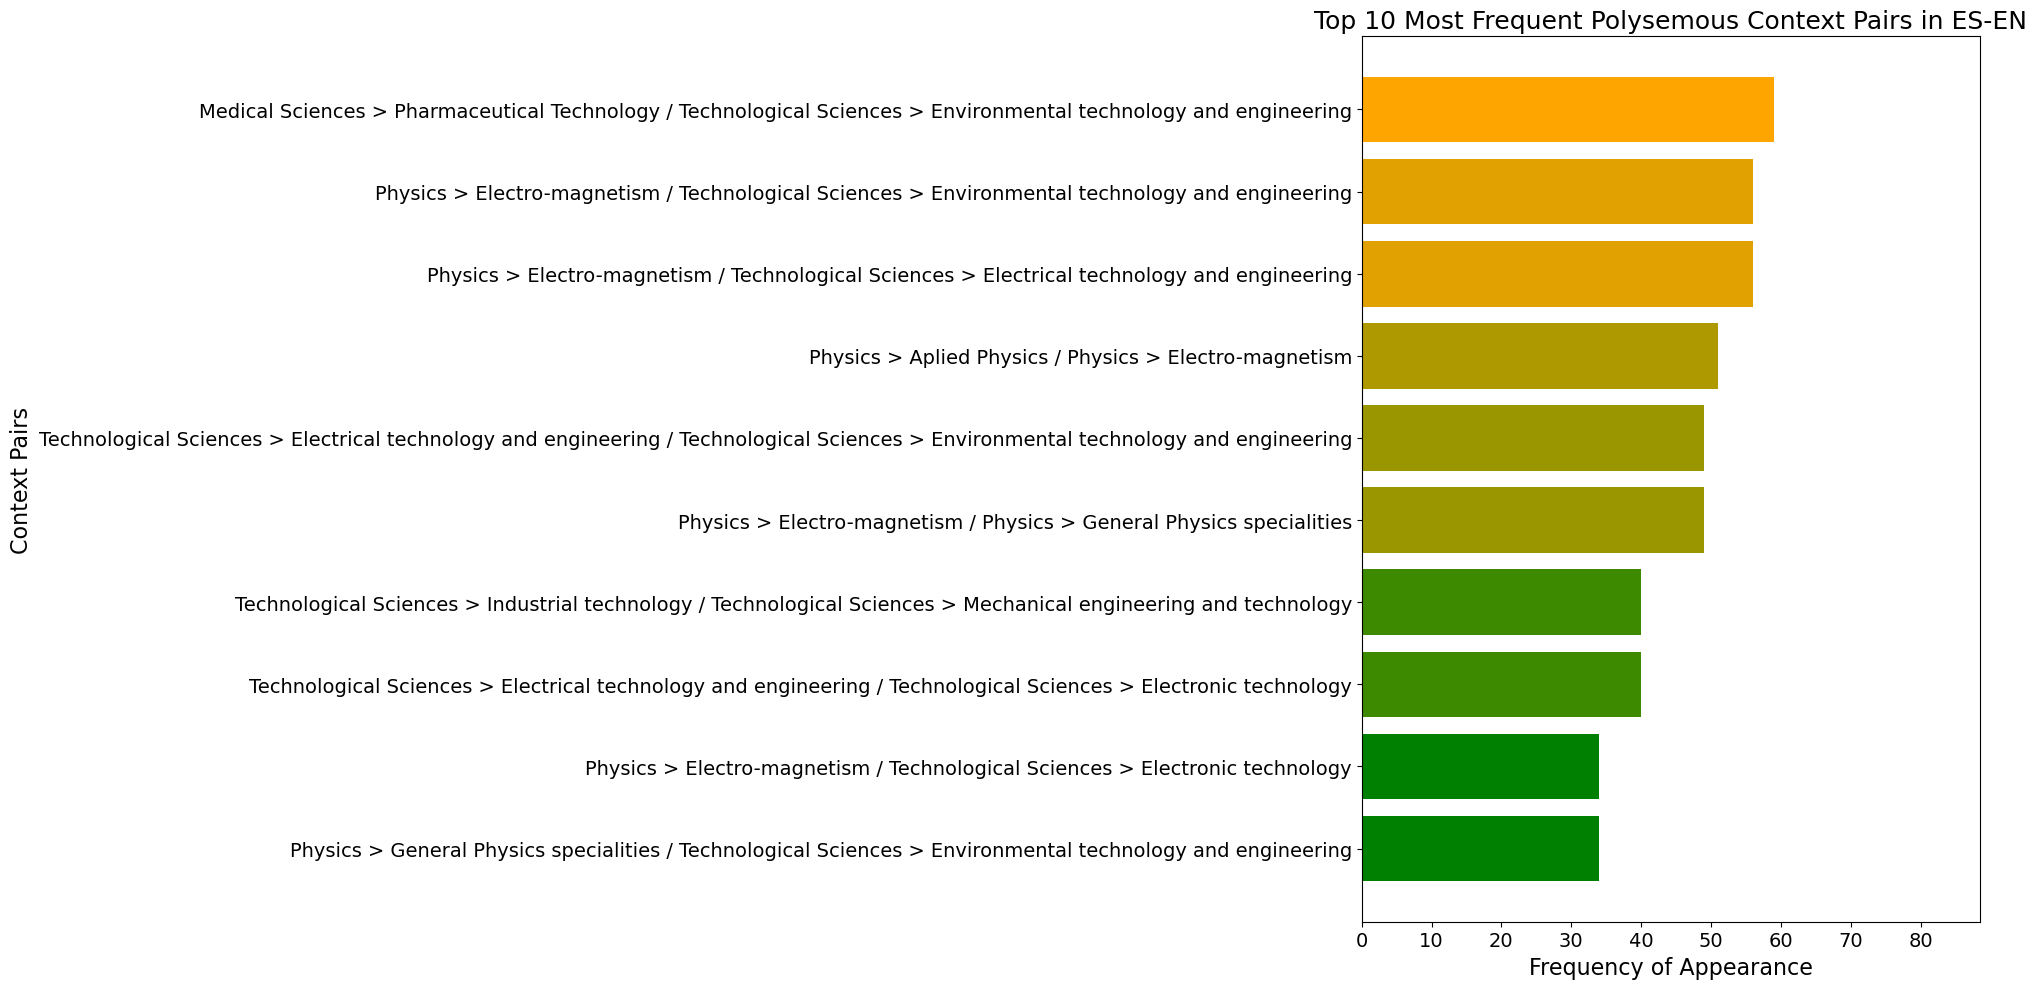

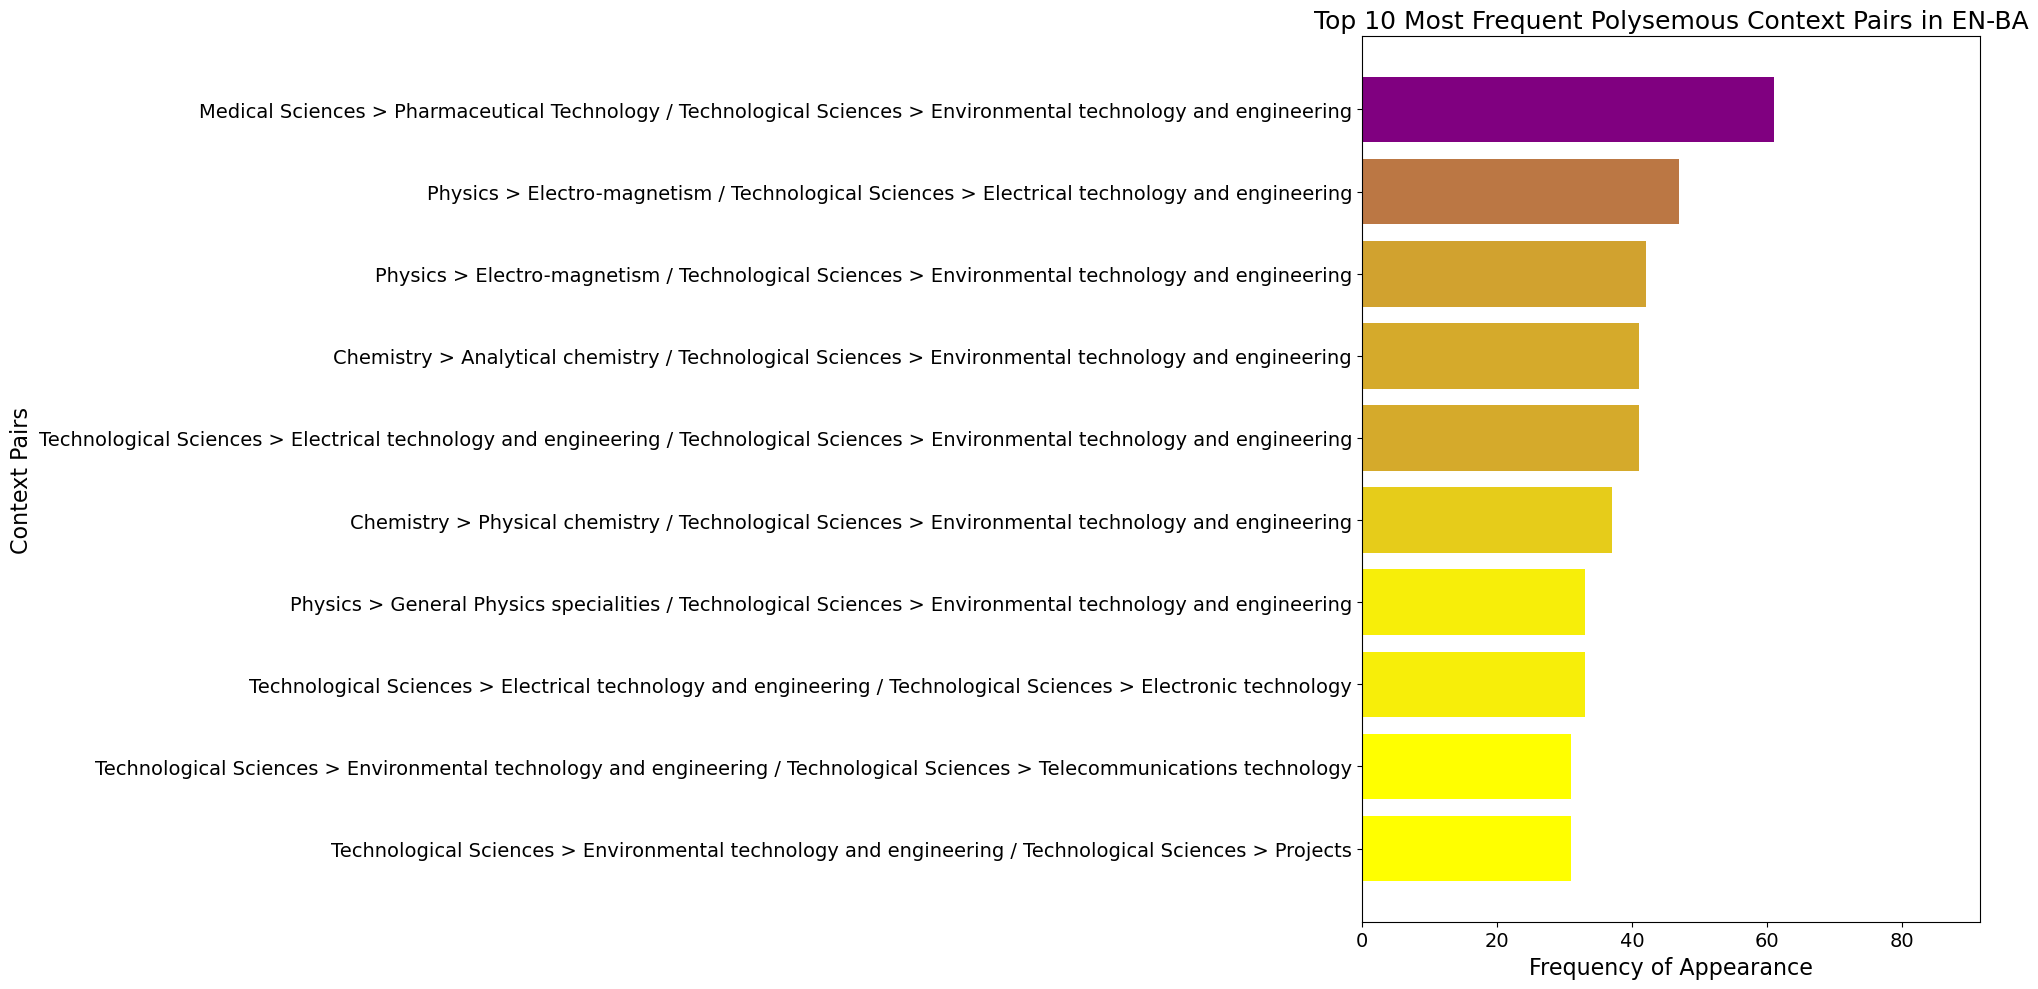

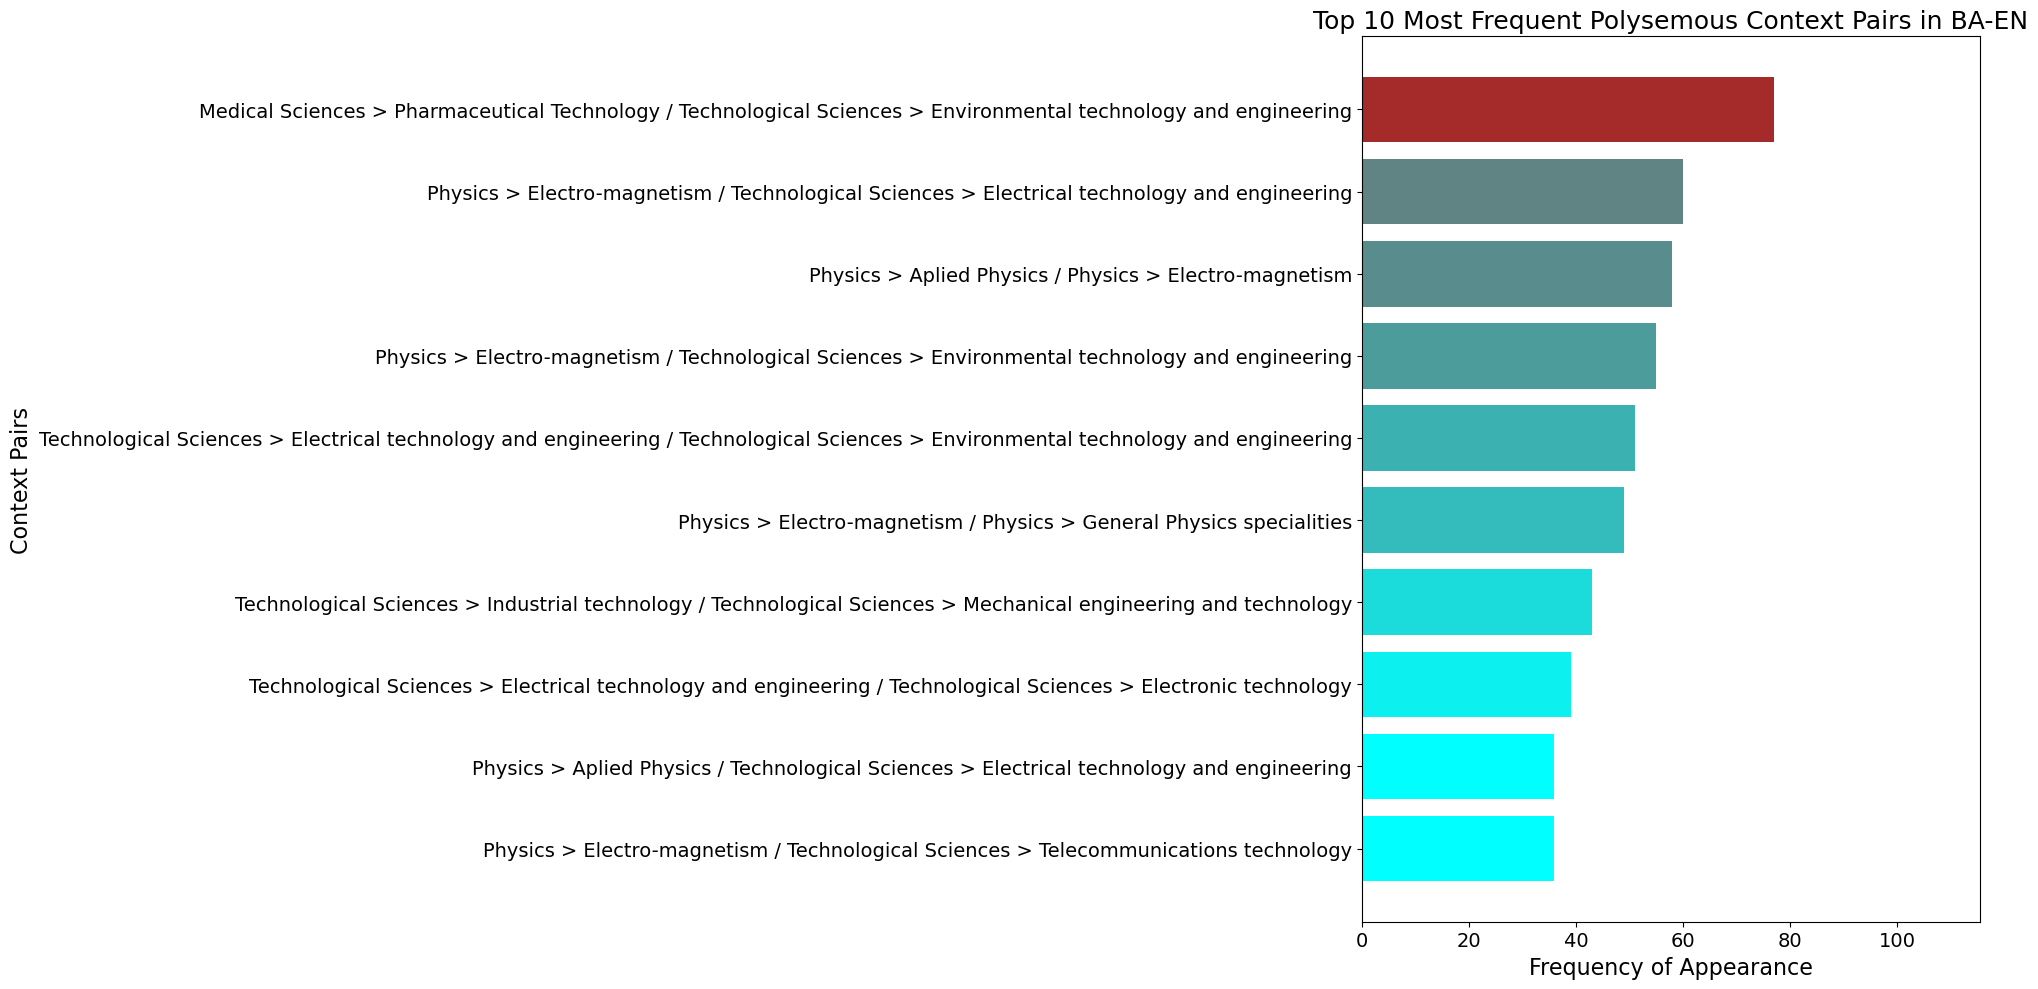

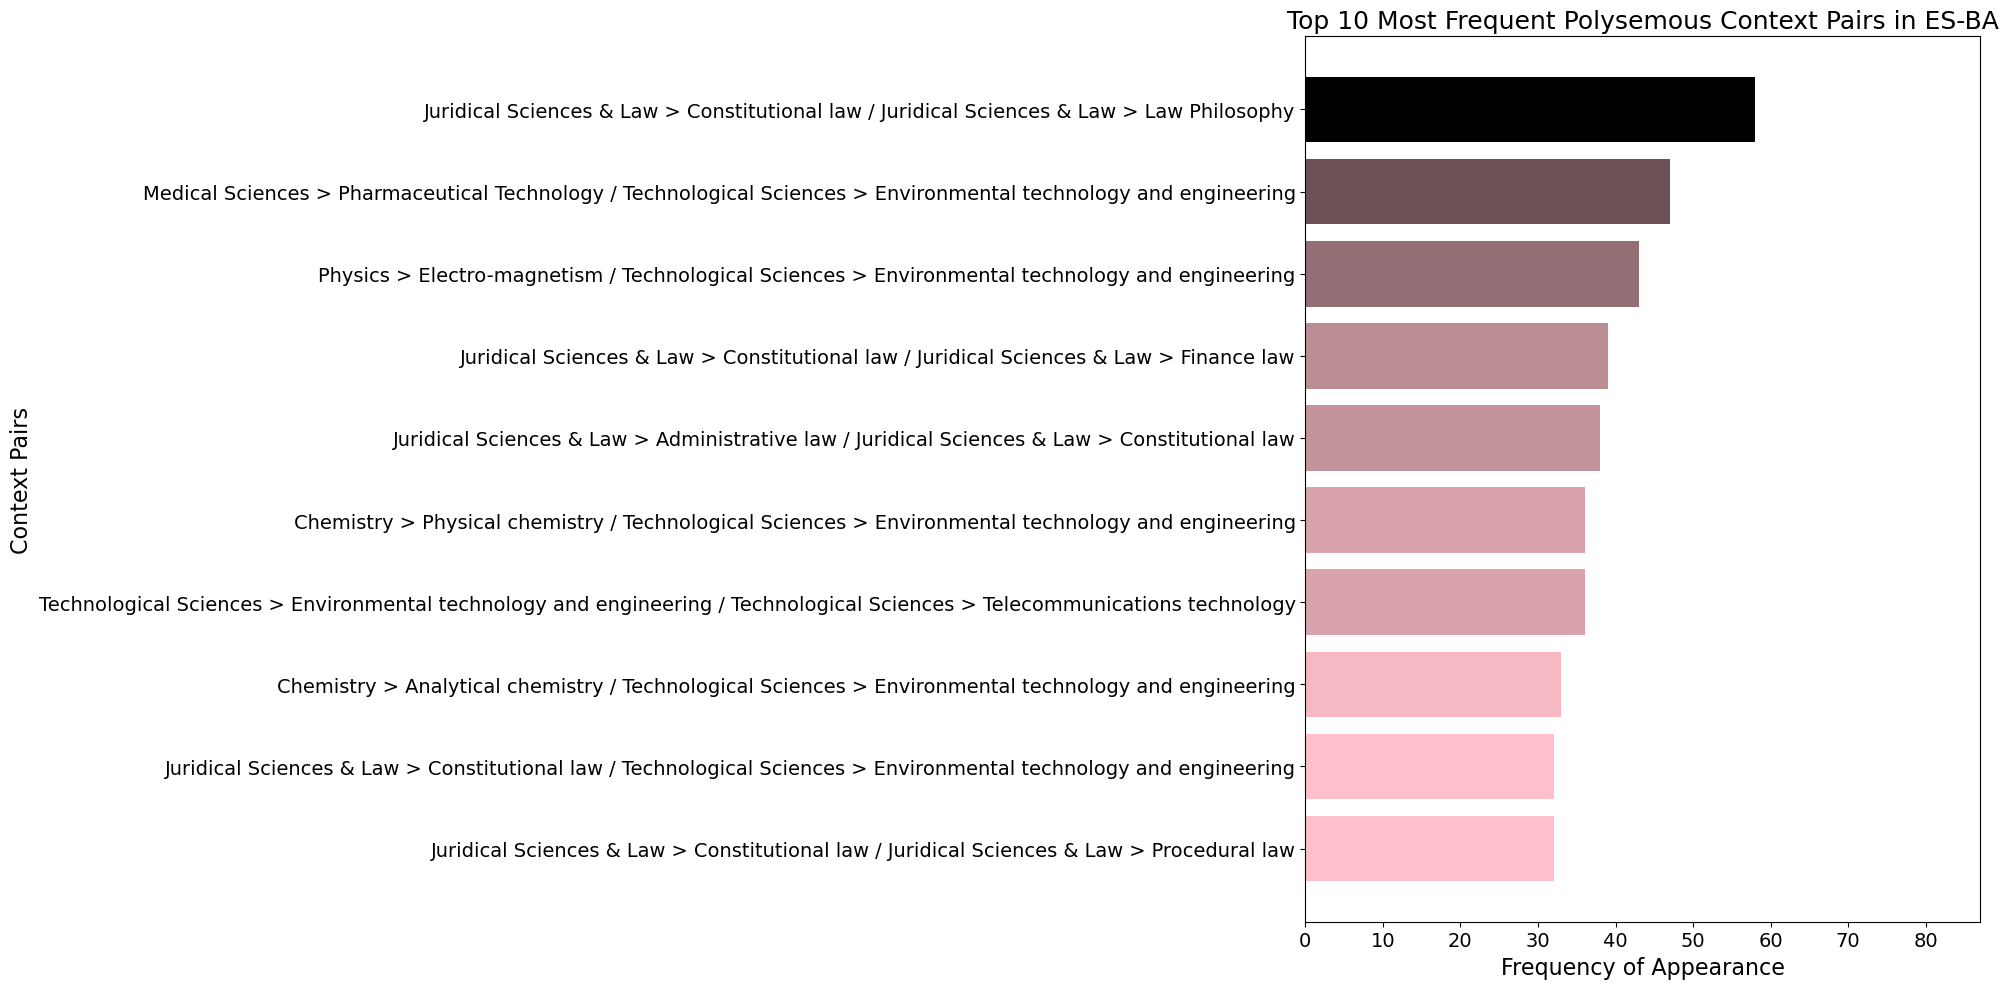

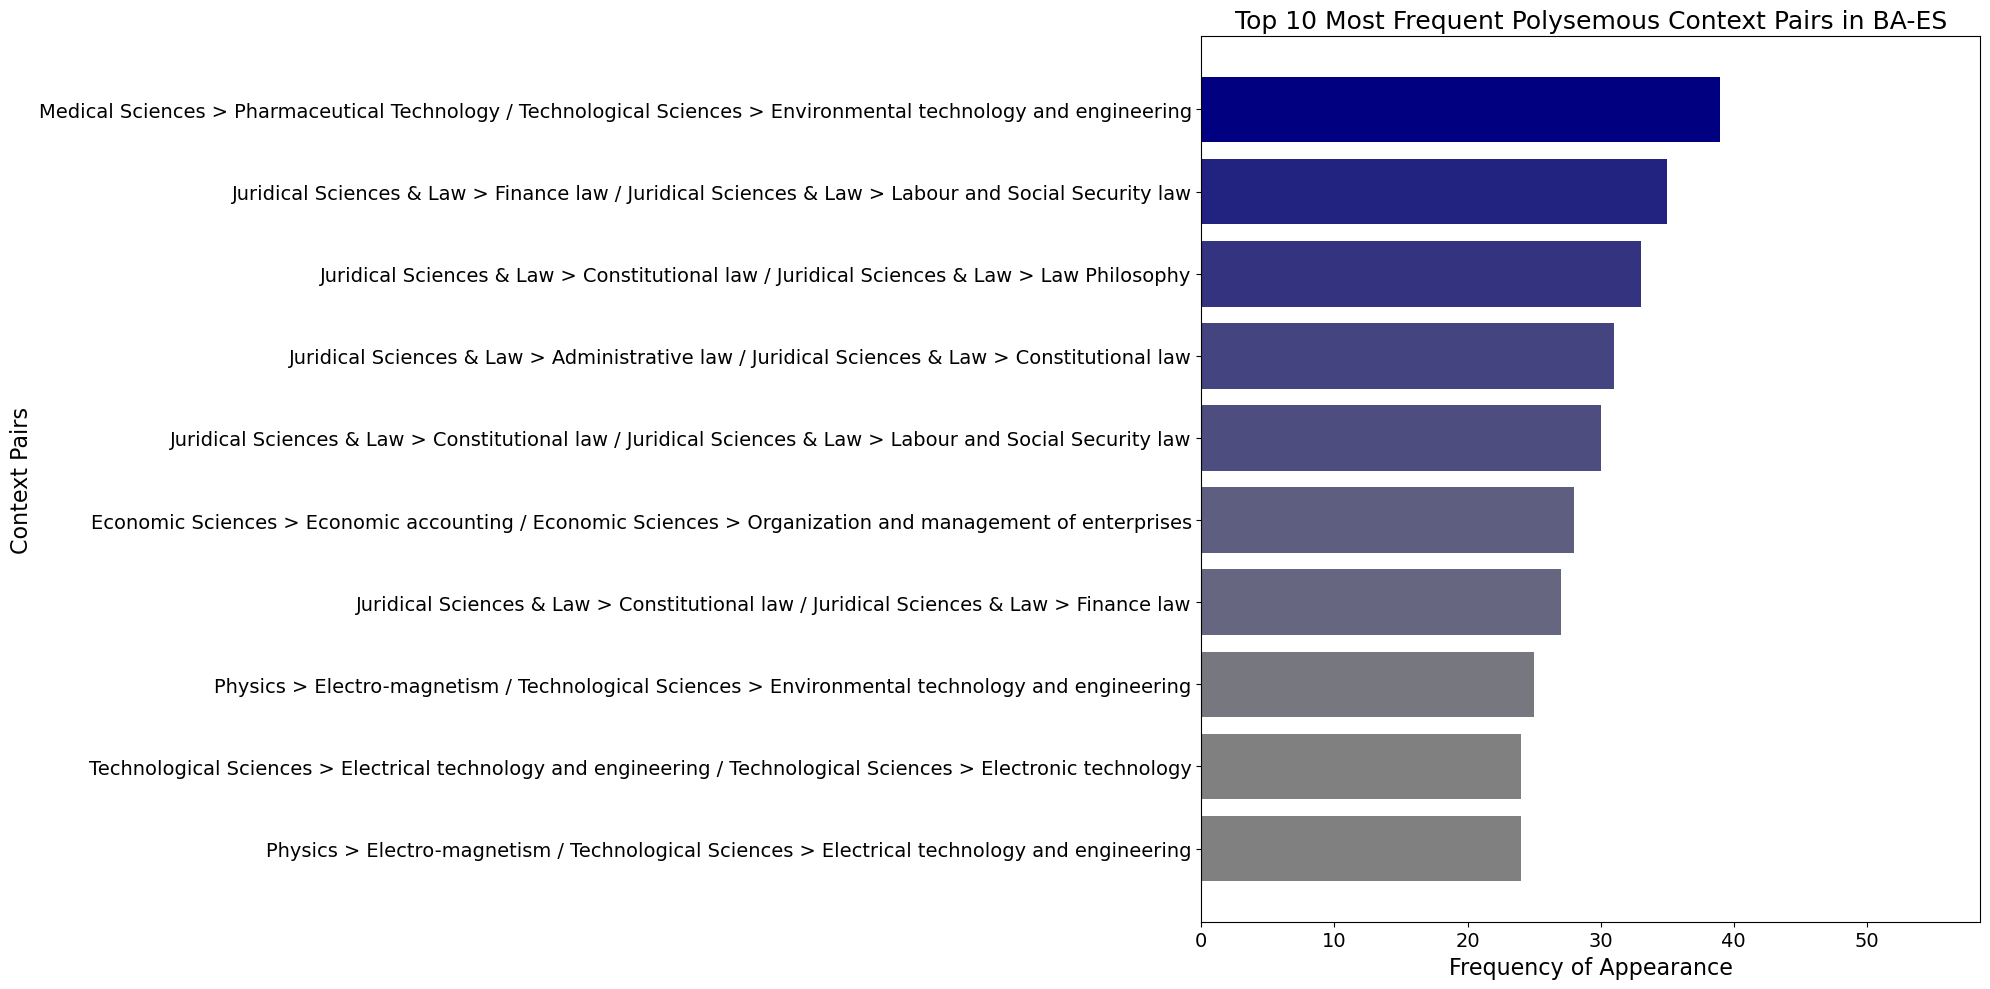

In [32]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from collections import Counter

# Define contrasting color pairs for each graph
color_schemes = [
    ("red", "blue"),        # EN-ES
    ("green", "orange"),    # ES-EN
    ("yellow", "purple"),   # EN-BA
    ("cyan", "brown"),      # BA-EN
    ("pink", "black"),      # ES-BA
    ("gray", "navy")        # BA-ES
]

# Iterate over the results of each DataFrame and generate graphs
for index, (dataframe, language_pair) in enumerate(dataframes_with_names):
    term_context_mapping = {}

    # Populate the dictionary with terms and their unique contexts
    for _, row in dataframe.iterrows():
        term = row['term']
        context = row['context']
        translation = row['translation']

        if term not in term_context_mapping:
            term_context_mapping[term] = {}
        if context not in term_context_mapping[term]:
            term_context_mapping[term][context] = set()

        term_context_mapping[term][context].add(translation)

    # Count pairs of contexts with different translations
    context_pair_counter = Counter()

    for term, contexts in term_context_mapping.items():
        context_list = list(contexts.keys())
        for i in range(len(context_list)):
            for j in range(i + 1, len(context_list)):
                context1, context2 = context_list[i], context_list[j]
                translations1 = contexts[context1]
                translations2 = contexts[context2]

                # Only count if the translations are different
                if translations1 != translations2:
                    context_pair = tuple(sorted([context1, context2]))
                    context_pair_counter[context_pair] += 1

    # Retrieve the 10 most frequent context pairs for this DataFrame
    top_10_context_pairs = context_pair_counter.most_common(10)

    # Prepare data for the graph
    pairs, counts = zip(*sorted(top_10_context_pairs, key=lambda x: x[1], reverse=True))
    pair_labels = [f"{p[0]} / {p[1]}" for p in pairs]

    # Create a unique gradient color map for each graph using the corresponding color pair
    color_map = LinearSegmentedColormap.from_list(f"color_map_{language_pair}", color_schemes[index])
    color_normalizer = plt.Normalize(min(counts), max(counts))
    bar_colors = color_map(color_normalizer(counts))  # Generate gradient colors for each bar

    # Create the horizontal bar chart
    plt.figure(figsize=(20, 10))
    plt.barh(pair_labels, counts, color=bar_colors)

    # Adjust the x-axis limit to extend bars and add margin
    plt.xlim(0, max(counts) * 1.5)

    # Add labels and title
    plt.xlabel('Frequency of Appearance', fontsize=16)
    plt.ylabel('Context Pairs', fontsize=16)
    plt.title(f'Top 10 Most Frequent Polysemous Context Pairs in {language_pair}', fontsize=18)
    plt.gca().invert_yaxis()  # Invert y-axis for better readability
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()

    # Save the graph with a unique file name
    plt.savefig(f'pair_graphics/top_10_pairs_{language_pair}.png', dpi=300, bbox_inches='tight')
    plt.show()


# SAVE TO DESTINATION FOLDERS

In [33]:
import re # Importing the regex library

# Create destination folder
destination_folder = 'pair_lists/EN_ES/'
os.makedirs(destination_folder, exist_ok=True)
print(f"Folder created or already exists: {destination_folder}")

def sanitize_filename(filename):
    # Replace any invalid characters for file names
    return re.sub(r'[<>:"/\\|?*]', '~', filename)

# Iterate over the most frequent context pairs
for context_pair, occurrence_count in top_10_context_pairs:
    context1, context2 = context_pair
    output_file_path = os.path.join(destination_folder, f"[{sanitize_filename(context1)}]_and_[{sanitize_filename(context2)}].csv")

    # List to store the data
    data_to_save = []

    for term, contexts in term_context_mapping.items():
        if context1 in contexts and context2 in contexts:
            translations_context1 = contexts[context1]
            translations_context2 = contexts[context2]

            # Add data only if translations are different
            if translations_context1 != translations_context2:
                for translation1 in translations_context1:
                    data_to_save.append([term, translation1, context1])
                for translation2 in translations_context2:
                    data_to_save.append([term, translation2, context2])

    # Check if data was found before saving
    if data_to_save:
        # Create DataFrame and save as CSV
        output_df = pd.DataFrame(data_to_save, columns=['Term', 'Translation', 'Context'])
        output_df.to_csv(output_file_path, index=False, encoding='utf-8')
        print(f"File saved: {output_file_path} (contains {len(data_to_save)} rows)")
    else:
        print(f"No data found for the pair: {context1} and {context2}")


Folder created or already exists: pair_lists/EN_ES/
File saved: pair_lists/EN_ES/[Medical Sciences ~ Pharmaceutical Technology]_and_[Technological Sciences ~ Environmental technology and engineering].csv (contains 78 rows)
File saved: pair_lists/EN_ES/[Juridical Sciences & Law ~ Finance law]_and_[Juridical Sciences & Law ~ Labour and Social Security law].csv (contains 70 rows)
File saved: pair_lists/EN_ES/[Juridical Sciences & Law ~ Constitutional law]_and_[Juridical Sciences & Law ~ Law Philosophy].csv (contains 66 rows)
File saved: pair_lists/EN_ES/[Juridical Sciences & Law ~ Administrative law]_and_[Juridical Sciences & Law ~ Constitutional law].csv (contains 62 rows)
File saved: pair_lists/EN_ES/[Juridical Sciences & Law ~ Constitutional law]_and_[Juridical Sciences & Law ~ Labour and Social Security law].csv (contains 60 rows)
File saved: pair_lists/EN_ES/[Economic Sciences ~ Economic accounting]_and_[Economic Sciences ~ Organization and management of enterprises].csv (contains 56

In [34]:
import re # Importing the regex library

# Define destination folder paths for each DataFrame
destination_folders = [
    'pair_lists/EN_ES/',
    'pair_lists/ES_EN/',
    'pair_lists/EN_BA/',
    'pair_lists/BA_EN/',
    'pair_lists/ES_BA/',
    'pair_lists/BA_ES/'
]

# Iterate over DataFrames and their corresponding destination folders
for (dataframe, language_pair), folder_path in zip(dataframes_with_names, destination_folders):
    # Create the destination folder if it does not exist
    os.makedirs(folder_path, exist_ok=True)
    print(f"Folder created or already exists: {folder_path}")

    # Dictionary to store terms and their unique contexts
    term_context_mapping = {}

    # Populate the dictionary with terms and their unique contexts
    for _, row in dataframe.iterrows():
        term = row['term']
        context = row['context']
        translation = row['translation']

        if term not in term_context_mapping:
            term_context_mapping[term] = {}
        if context not in term_context_mapping[term]:
            term_context_mapping[term][context] = set()

        term_context_mapping[term][context].add(translation)

    # Count pairs of contexts with different translations
    context_pair_counter = Counter()

    for term, contexts in term_context_mapping.items():
        context_list = list(contexts.keys())
        for i in range(len(context_list)):
            for j in range(i + 1, len(context_list)):
                context1, context2 = context_list[i], context_list[j]
                translations1 = contexts[context1]
                translations2 = contexts[context2]

                # Count only if the translations are different
                if translations1 != translations2:
                    context_pair = tuple(sorted([context1, context2]))
                    context_pair_counter[context_pair] += 1

    # Retrieve the 10 most frequent context pairs for this DataFrame
    top_10_context_pairs = context_pair_counter.most_common(10)

    # Save the most frequent context pairs to CSV files
    for context_pair, count in top_10_context_pairs:
        context1, context2 = context_pair
        output_file = os.path.join(folder_path, f"[{sanitize_filename(context1)}]_and_[{sanitize_filename(context2)}].csv")

        # List to store the data for the CSV
        csv_data = []

        for term, contexts in term_context_mapping.items():
            if context1 in contexts and context2 in contexts:
                translations1 = contexts[context1]
                translations2 = contexts[context2]

                # Add data only if the translations are different
                if translations1 != translations2:
                    for translation1 in translations1:
                        csv_data.append([term, translation1, context1])
                    for translation2 in translations2:
                        csv_data.append([term, translation2, context2])

        # Check if data was found before saving
        if csv_data:
            # Create a DataFrame and save it as a CSV file
            output_df = pd.DataFrame(csv_data, columns=['Term', 'Translation', 'Context'])
            output_df.to_csv(output_file, index=False, encoding='utf-8')
            print(f"File saved: {output_file} (contains {len(csv_data)} rows)")
        else:
            print(f"No data found for the pair: {context1} and {context2}")


Folder created or already exists: pair_lists/EN_ES/
File saved: pair_lists/EN_ES/[Medical Sciences ~ Pharmaceutical Technology]_and_[Technological Sciences ~ Environmental technology and engineering].csv (contains 78 rows)
File saved: pair_lists/EN_ES/[Physics ~ Electro-magnetism]_and_[Technological Sciences ~ Electrical technology and engineering].csv (contains 74 rows)
File saved: pair_lists/EN_ES/[Technological Sciences ~ Electrical technology and engineering]_and_[Technological Sciences ~ Environmental technology and engineering].csv (contains 60 rows)
File saved: pair_lists/EN_ES/[Technological Sciences ~ Environmental technology and engineering]_and_[Technological Sciences ~ Projects].csv (contains 54 rows)
File saved: pair_lists/EN_ES/[Physics ~ Electro-magnetism]_and_[Technological Sciences ~ Environmental technology and engineering].csv (contains 54 rows)
File saved: pair_lists/EN_ES/[Chemistry ~ Analytical chemistry]_and_[Technological Sciences ~ Environmental technology and 